In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Loading the data
solar_data = pd.read_csv("solar-pv-prices.csv")

# Displaying the first few rows of the data
solar_data.head()

,Entity,Code,Year,Solar photovoltaic module price
0,World,OWID_WRL,1975,115.279940
1,World,OWID_WRL,1976,86.734980
2,World,OWID_WRL,1977,63.277240
3,World,OWID_WRL,1978,44.769016
4,World,OWID_WRL,1979,37.616653


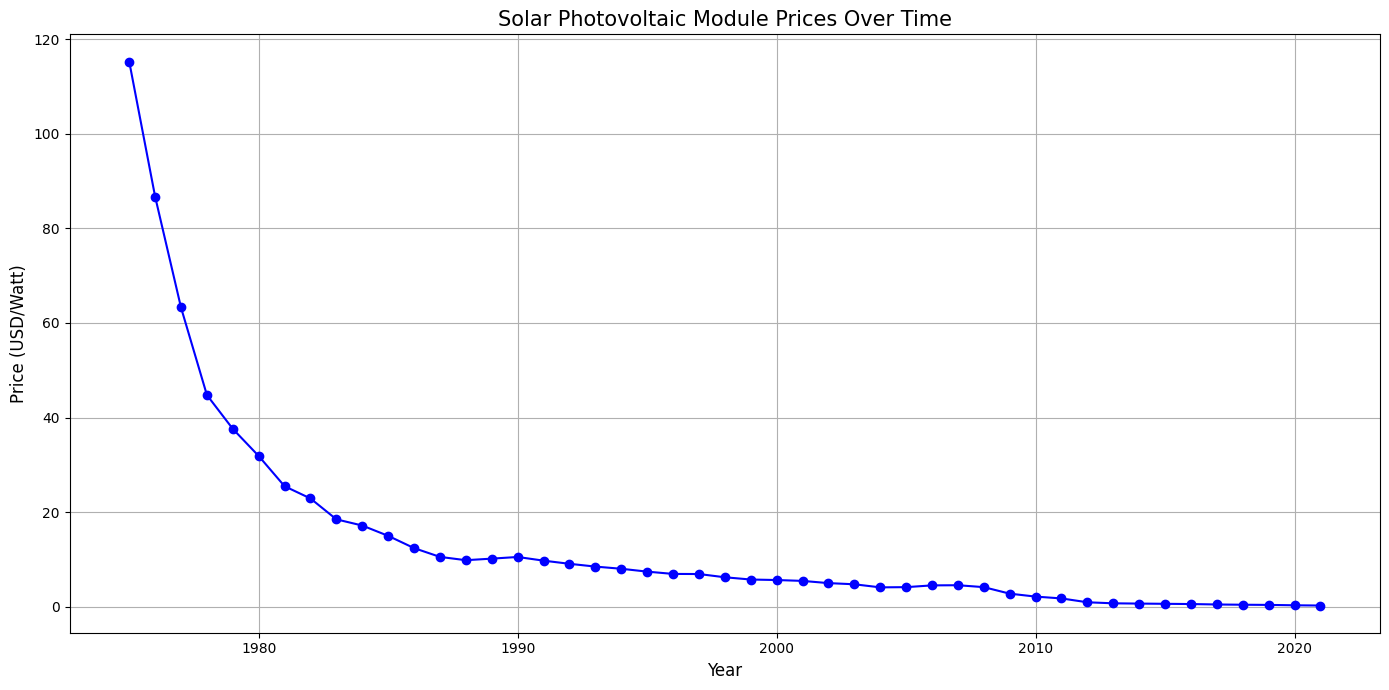

In [ ]:
# Visualizing the solar photovoltaic module prices over the years
plt.figure(figsize=(14, 7))
plt.plot(solar_data['Year'], solar_data['Solar photovoltaic module price'], marker='o', linestyle='-', color='blue')
plt.title('Solar Photovoltaic Module Prices Over Time', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD/Watt)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

LINEAR REGRESSION

In [ ]:
# Create a "Year since start" feature
solar_data['Years_since_start'] = solar_data['Year'] - solar_data['Year'].min()

# Splitting data into training and testing sets (80% train, 20% test)
X = solar_data[['Years_since_start']]
y = solar_data['Solar photovoltaic module price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and training the linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicting on the test set
y_pred = lr.predict(X_test)

# Calculating the Mean Squared Error (MSE) for the predictions
mse = mean_squared_error(y_test, y_pred)

mse

72.8274574426924

PREDICTION

In [ ]:
# Predicting prices for the years 2022 to 2027
future_years = np.array(range(2022, 2028)).reshape(-1, 1)
future_years_since_start = future_years - solar_data['Year'].min()

# Using the trained model to predict prices
predicted_prices = lr.predict(future_years_since_start)

# Combining the years and predictions for a clear representation
predictions = pd.DataFrame({'Year': future_years.ravel(), 'Predicted Price (USD/Watt)': predicted_prices})

predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Year,Predicted Price (USD/Watt)
0,2022,-14.260250
1,2023,-15.467271
2,2024,-16.674291
3,2025,-17.881312
4,2026,-19.088332
5,2027,-20.295353


the predicted prices are negative, which is not physically meaningful. This indicates a limitation of the linear regression model when extrapolating beyond the data range. The negative values could be due to the strong linear downward trend in the training data.

ARIMA

In [ ]:
# Data for ARIMA
X_arima = solar_data.set_index('Year')['Solar photovoltaic module price']

# Fitting the ARIMA model
# The parameters (p,d,q) are chosen based on the nature of the data and can be tuned further for optimal performance
model = ARIMA(X_arima, order=(5,1,0))
# Fitting the ARIMA model without the "disp" argument
model_fit = model.fit()

# Directly forecasting the values for 2022 to 2027 using the ARIMA model
forecast_results = model_fit.forecast(steps=6)

# Extracting the forecasted values correctly
forecasted_values = forecast_results.values

# Creating a DataFrame for the forecasted values
forecast_df = pd.DataFrame({
    'Year': np.arange(2022, 2028),
    'Predicted Price (USD/Watt)': forecasted_values
})

forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

,Year,Predicted Price (USD/Watt)
0,2022,0.209751
1,2023,0.136346
2,2024,0.085335
3,2025,0.023142
4,2026,-0.039226
5,2027,-0.089142


In [ ]:
# Using the ARIMA model to predict on the test data
arima_predictions = model_fit.forecast(steps=len(X_test))

# Calculating the Mean Squared Error (MSE) for the ARIMA predictions on the test data
arima_mse = mean_squared_error(y_test, arima_predictions)

arima_mse

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


174.0434468173355

In [ ]:
# Using a different approach to align predictions with the test set
start_point = len(X_arima) - len(X_test)
end_point = len(X_arima) - 1
arima_predictions_aligned = model_fit.predict(start=start_point, end=end_point).values

# Recalculating MAPE and MAE

# MAPE (avoiding division by zero)
mape = np.mean(np.abs((y_test - arima_predictions_aligned) / (y_test + 1e-10))) * 100

# MAE
mae = np.mean(np.abs(y_test - arima_predictions_aligned))

mape, mae

(75.35268283985167, 7.544968632668214)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


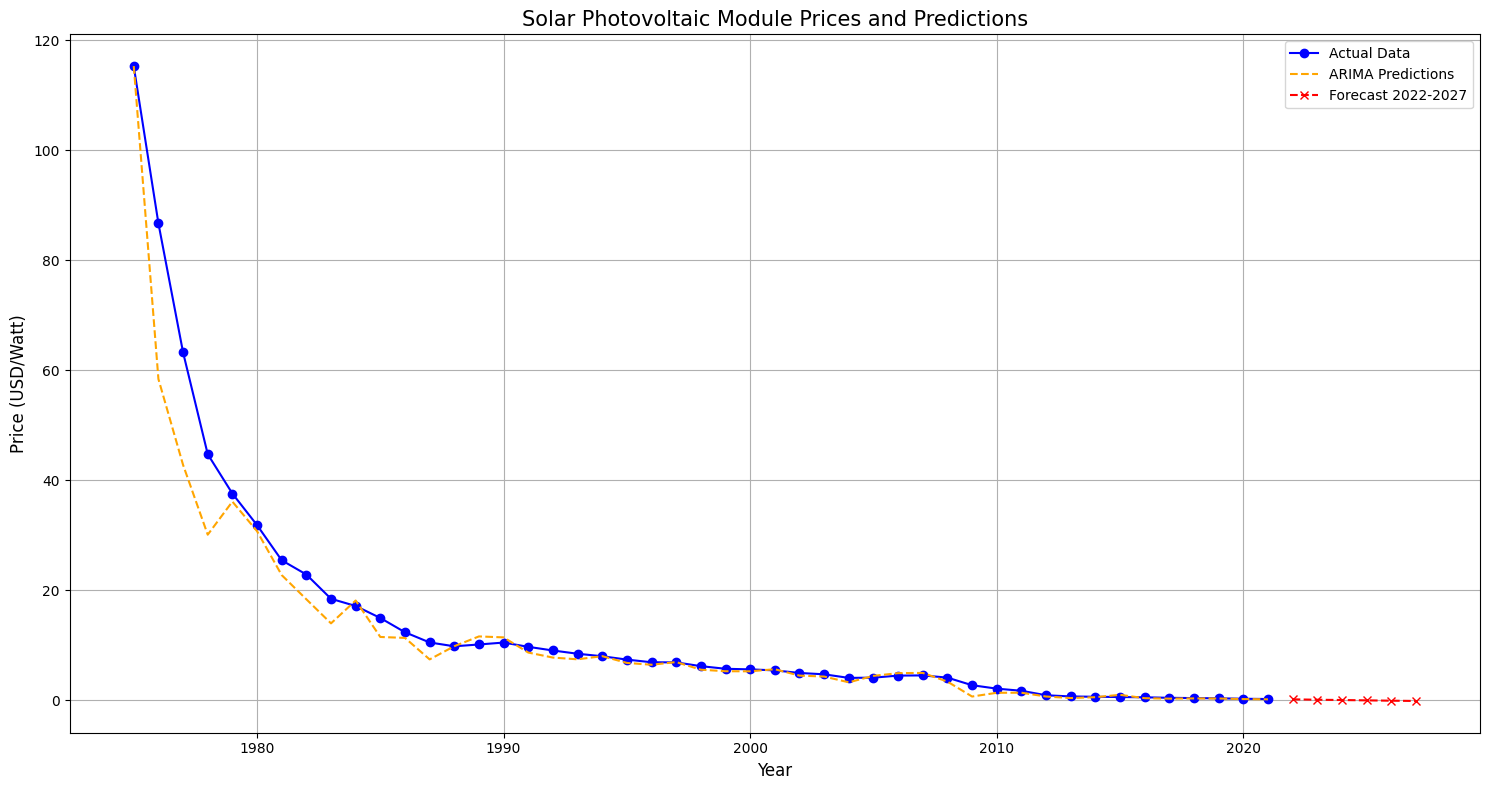

In [ ]:
# Predictions for the entire dataset to visualize the fit
entire_predictions = model_fit.predict(start=1, end=len(X_arima))

# Forecast for the years 2022 to 2027
forecast_2022_2027 = model_fit.forecast(steps=6)

# Plotting the data, model predictions, and future forecast
plt.figure(figsize=(15, 8))
plt.plot(solar_data['Year'], solar_data['Solar photovoltaic module price'], label='Actual Data', color='blue', marker='o')
plt.plot(solar_data['Year'], entire_predictions, label='ARIMA Predictions', color='orange', linestyle='--')
plt.plot(np.arange(2022, 2028), forecast_2022_2027, label='Forecast 2022-2027', color='red', linestyle='--', marker='x')

plt.title('Solar Photovoltaic Module Prices and Predictions', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD/Watt)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()